## コーディングテスト

In [1]:
# 必要なモジュール
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 21)

# random seedを設定
SEED = 42

## 使用データについて
今回は、Telco Customer Churnというデータセットを使用する。客が解約(churn)するかどうかを予測するのが目的である。表形式データで、サイズが割と小さく、カテゴリカル変数が多い。

In [22]:
df = pd.read_csv('../data/churn_data.csv')
print(f'データシェイプ: {df.shape}')
df.head()

データシェイプ: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 問題1
本データに対し、customerIDを削除しなさい。<br>
また、TotalChargesに不適切な値" "が含まれているため、0で補間しデータを浮動小数点数型に変更しなさい

In [23]:
#　　回答
df = df.drop("customerID", axis=1)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0.0)
q7_df = df.copy()

### 問題2
カテゴリカル変数とターゲットに対し、label encodingを適用しなさい。

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
#　　回答

kcolumns = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", 
    "Contract", "PaperlessBilling",  "PaymentMethod", "Churn"
]

le = LabelEncoder()

for col in kcolumns:
    encoded = le.fit_transform(df[col].values)
    df[col] = encoded

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


### 問題3
label encodingを適用したデータを、学習用と評価用に分け、500本の木のRandom Forest(他のパラメータがデフォルトで、seedも忘れないこと)を学習し、評価データに対してアキュラシーを測り、学習と予測の時間を測りなさい。<br>
学習用と評価用は8:2に分割し、分割時にはstratificationを適用しなさい

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

In [7]:
# 回答

y = df["Churn"].values
X = df[df.columns[df.columns != "Churn"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

forest = RandomForestClassifier(n_estimators=500, random_state=SEED)

start = time.time()
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
end = time.time()
print(f"かかった時間：　{round(end-start)}秒")
accuracy_score = accuracy_score(y_test, y_pred)
print(f"accuracy score is {accuracy_score}")

かかった時間：　16秒
accuracy score is 0.8076650106458482


### 問題4
前に学習したモデルを使って、評価データに対するROC AUCを計算しなさい。

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve

AUC is 0.722


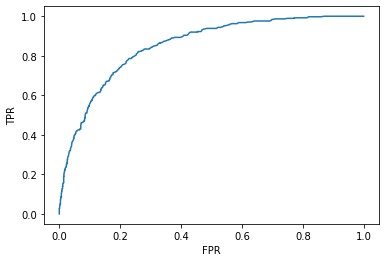

In [13]:
# 回答
import matplotlib.pyplot as plt

auc = roc_auc_score(y_test, y_pred)
print(f'AUC is {round(auc,3)}')

proba_rf = forest.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, proba_rf)
plt.plot(fpr, tpr)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### 問題5
前にデータを学習・評価に分割したが、今回はホールドアウト法を利用するため、学習データをさらに学習・検証に分割しなさい。<br>
学習、検証、評価の比率は6:2:2とし、学習と検証の分割時にはstratificationを適用しなさい。<br> 
また、Random Forestのcriterionというパラメータを変えて、ホールドアウト法によってモデルをROC AUCで比較しなさい。

In [15]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

### 問題6
今回のデータに対し、学習、評価データを8:2に分割の上、k = 4でk分割交差検証を行いなさい。<br>
データの分割時には、stratificationを適用しなさい。<br>
また、できた4個のモデルの平均アンサンブルをROC AUCで評価しなさい。

In [16]:
# 回答

rf_model = RandomForestClassifier(n_estimators=500, random_state=SEED)
cv = StratifiedKFold(n_splits=4, random_state=SEED)

rf_scores = cross_val_score(rf_model, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
kfold_auc = np.mean(rf_scores)

print(f"AUC in KFold is {round(kfold_auc,2)}")

AUC in KFold is 0.82


### 問題7
問題6までは、label encodingを適用の上、モデル構築及び評価を行ったが、カテゴリカル変数に対しone-hot encodingを適用し、学習:評価を8:2に分割の上、k = 4でk分割交差検証を行いなさい。<br>
また、できた4個のモデルの平均アンサンブルをROC AUCで評価しなさい。

In [27]:
#回答
q7_df = pd.get_dummies(q7_df, drop_first=True)
q7_y = q7_df["Churn_Yes"].values
q7_X = q7_df[q7_df.columns[q7_df.columns != "Churn_Yes"]].values

rf_model = RandomForestClassifier(n_estimators=500, random_state=SEED)
cv = StratifiedKFold(n_splits=4, random_state=SEED)

rf_scores = cross_val_score(rf_model, q7_X, q7_y, scoring="roc_auc", cv=cv, n_jobs=-1)
kfold_auc = np.mean(rf_scores)

print(f"AUC in KFold (one-hot-encoding) is {round(kfold_auc,2)}")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


AUC in KFold (one-hot-encoding) is 0.82
